Module 사용을 위한 주피터 세션 세팅
- TF SLIM & OBJECT_DETECTOION API

In [1]:
# TF SLIM과 OBJECT_DETECTOION API를 사용하기 위한 PYTHON_PATH APPEND
# 최초 1회만 수행
import sys
import os

!export PYTHONPATH=$PYTHONPATH:/home/xerato/workspace/tmp/models:/home/xerato/workspace/tmp/models/research:/home/xerato/workspace/tmp/models/research/slim
PATH_OBJ_DETECTION="/home/xerato/workspace/models/research/object_detection/"            

sys.path.append("/home/xerato/workspace/models/research/object_detection/")
sys.path.append("/home/xerato/workspace/models/research/")

사용모듈 설정

In [2]:
import tensorflow as tf
print(tf.__version__) # 1.12 이상

import numpy as np
import six.moves.urllib as urllib

import tarfile
import zipfile
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from object_detection.utils import ops as utils_ops

from utils import label_map_util
from utils import visualization_utils as vis_util




1.13.1


모델설정, 프로즌그래프, 라벨링매퍼 파일설정

In [3]:
MODEL_NAME = 'faster_rcnn_inception_v2' # 후일 모델명에 맞게 스위치 할 수 있게 구현합니다.
PATH_TO_FROZEN_GRAPH = os.path.join(PATH_OBJ_DETECTION, 'inference_graph','frozen_inference_graph.pb')
PATH_TO_LABELS = os.path.join(PATH_OBJ_DETECTION, 'training', 'labelmap.pbtxt')
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

category_index 는 MAPPER임

In [4]:
category_index

{1: {'id': 1, 'name': 'Plastic_0'},
 2: {'id': 2, 'name': 'Plastic_1'},
 3: {'id': 3, 'name': 'Plastic_2'},
 4: {'id': 4, 'name': 'Plastic_3'},
 5: {'id': 5, 'name': 'Plastic_4'},
 6: {'id': 6, 'name': 'Plastic_5'},
 7: {'id': 7, 'name': 'Plastic_6'},
 8: {'id': 8, 'name': 'Plastic_7'},
 9: {'id': 9, 'name': 'Metal_0'},
 10: {'id': 10, 'name': 'Metal_1'},
 11: {'id': 11, 'name': 'Metal_2'},
 12: {'id': 12, 'name': 'Glass_0'},
 13: {'id': 13, 'name': 'Glass_1'},
 14: {'id': 14, 'name': 'Glass_2'},
 15: {'id': 15, 'name': 'Glass_3'},
 16: {'id': 16, 'name': 'Glass_4'},
 17: {'id': 17, 'name': 'Glass_5'},
 18: {'id': 18, 'name': 'Paper_0'},
 19: {'id': 19, 'name': 'Paper_1'},
 20: {'id': 20, 'name': 'Paper_2'},
 21: {'id': 21, 'name': 'Paper_3'},
 22: {'id': 22, 'name': 'Battery_0'},
 23: {'id': 23, 'name': 'Battery_1'},
 24: {'id': 24, 'name': 'Battery_2'},
 25: {'id': 25, 'name': 'Battery_3'}}

In [5]:
# 이미지를 NUMPY ARRAY로 리턴
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

학습된 모델그래프를 import

In [6]:
# faster_rcnn_inception_v2
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [11]:
def exec_test():
    for image_path in TEST_IMAGE_PATHS:
      print(image_path)
      # Pillow로 이미지 오픈.
      image = Image.open(image_path)
    
      # 넘파일배열로 변환  
      image_np = load_image_into_numpy_array(image)

      # 빈 차원 추가
      # 299(가로)x299(세로)x3(RGB) -> 1X299X299X3
      image_np_expanded = np.expand_dims(image_np, axis=0)

      # 이미지를 텐서세션에 넣고 돌림
      output_dict = run_inference_for_single_image(image_np, detection_graph)

      # 그 결과값을 이미지에 그려줌
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          output_dict['detection_boxes'],
          output_dict['detection_classes'],
          output_dict['detection_scores'],
          category_index, # TODO: 강결합. 제거할것
          instance_masks=output_dict.get('detection_masks'), # 세그먼트시 사용. 지워도 무방하나, 그냥 냅둡니다.
          use_normalized_coordinates=True, # 좌표사용값인데, False로 하면 바운딩박스가 안그려짐
          line_thickness=8,
          min_score_thresh=.1 # 최소보장 추측점수. 0.9로 할경우 90%이상의 스코어만 출력됨
      )
       
      
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)
      plt.show()

단일 이미지에 대해 이미지판별

TF SESSION이 실행되는 부분

이미지(프레임)과 훈련된가중치를 받음

In [12]:

def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
  
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        # 우리는 4개의 속성을 사용합니다.
        # 'num_detections', 'detection_boxes', 'detection_scores','detection_classes'
        
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])

        
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)

        
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
    
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})
    
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [13]:

# 테스트 이미지 경로
PATH_TO_TEST_IMAGES_DIR = '/home/xerato/workspace/models/research/object_detection/test_images'

# 테스트할 이미지파일명 : range부분 조정
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(11, 41) ]

# 출력 이미지 사이즈
# IMAGE_SIZE = (12, 12)
# IMAGE_SIZE = (22, 18)
IMAGE_SIZE = (22, 18)

/home/xerato/workspace/models/research/object_detection/test_images/image11.jpg


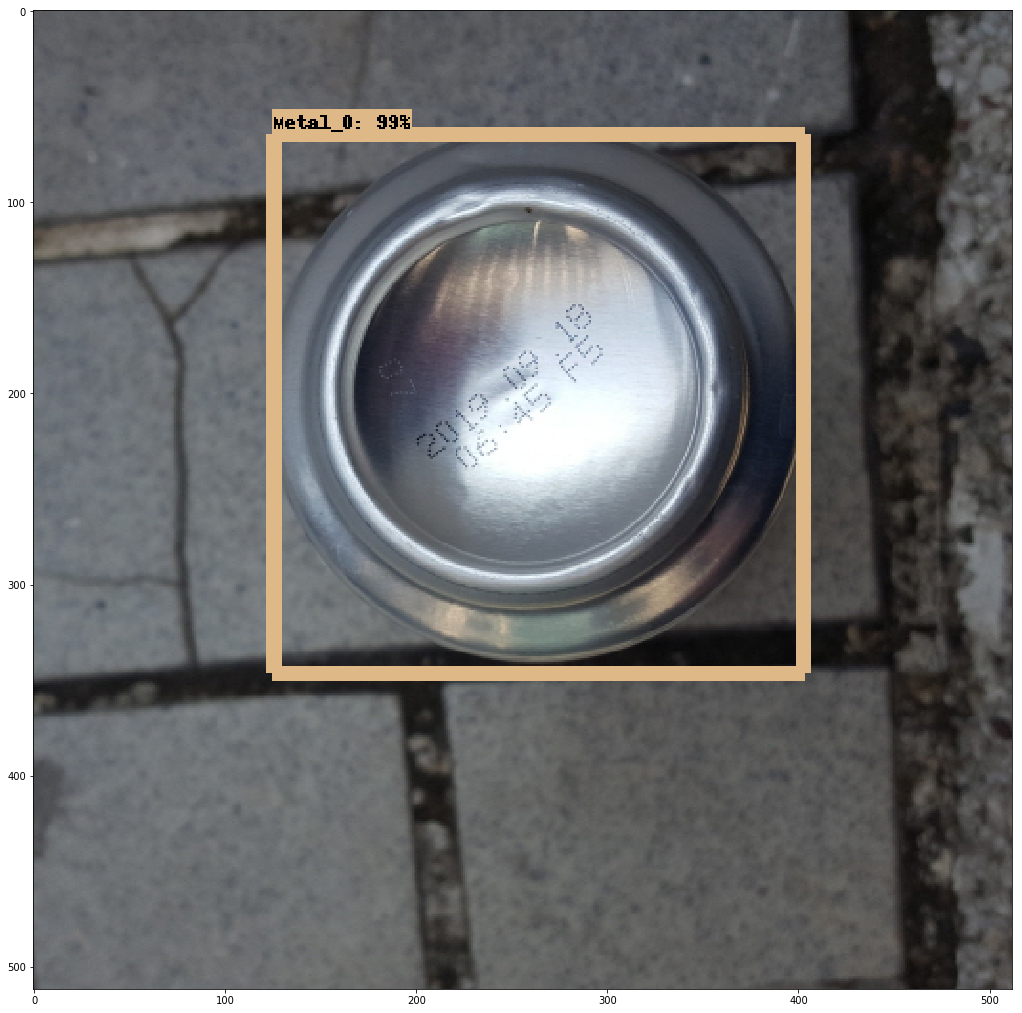

/home/xerato/workspace/models/research/object_detection/test_images/image12.jpg


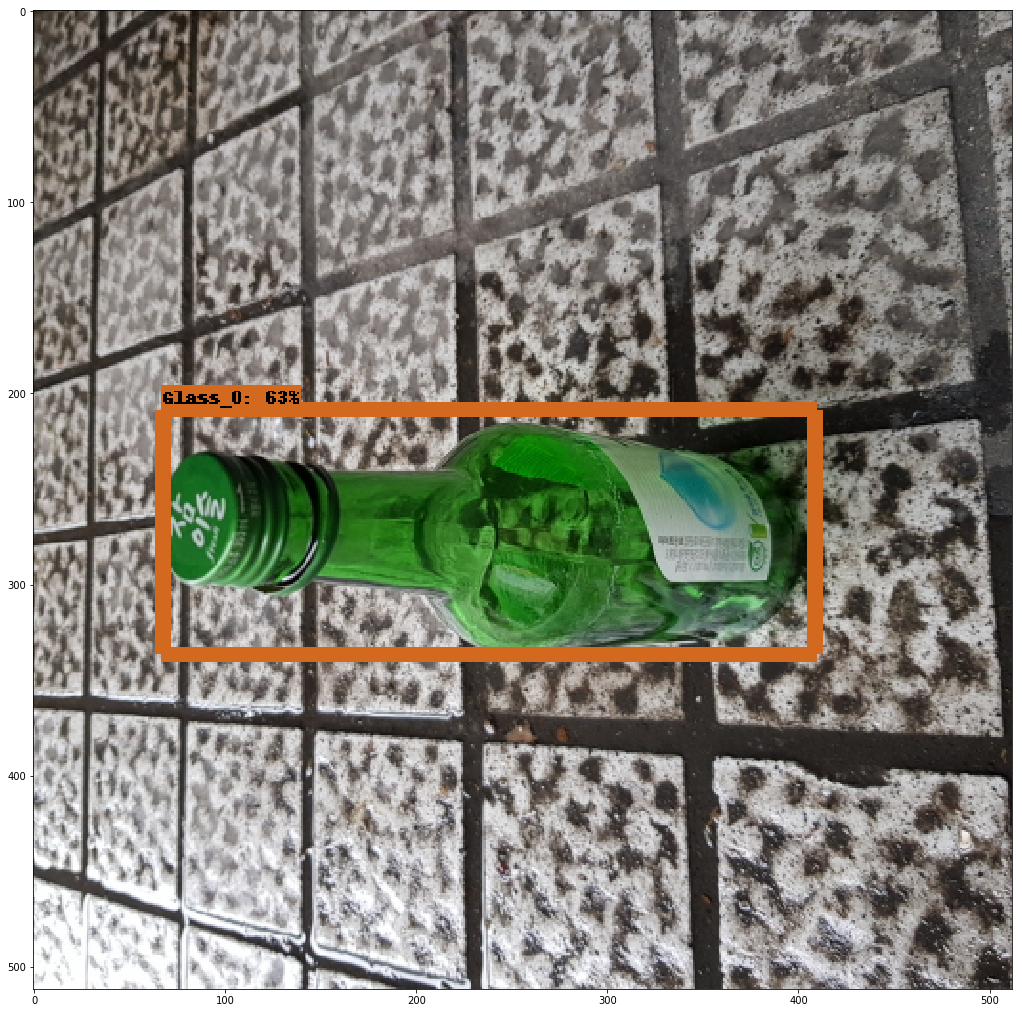

/home/xerato/workspace/models/research/object_detection/test_images/image13.jpg


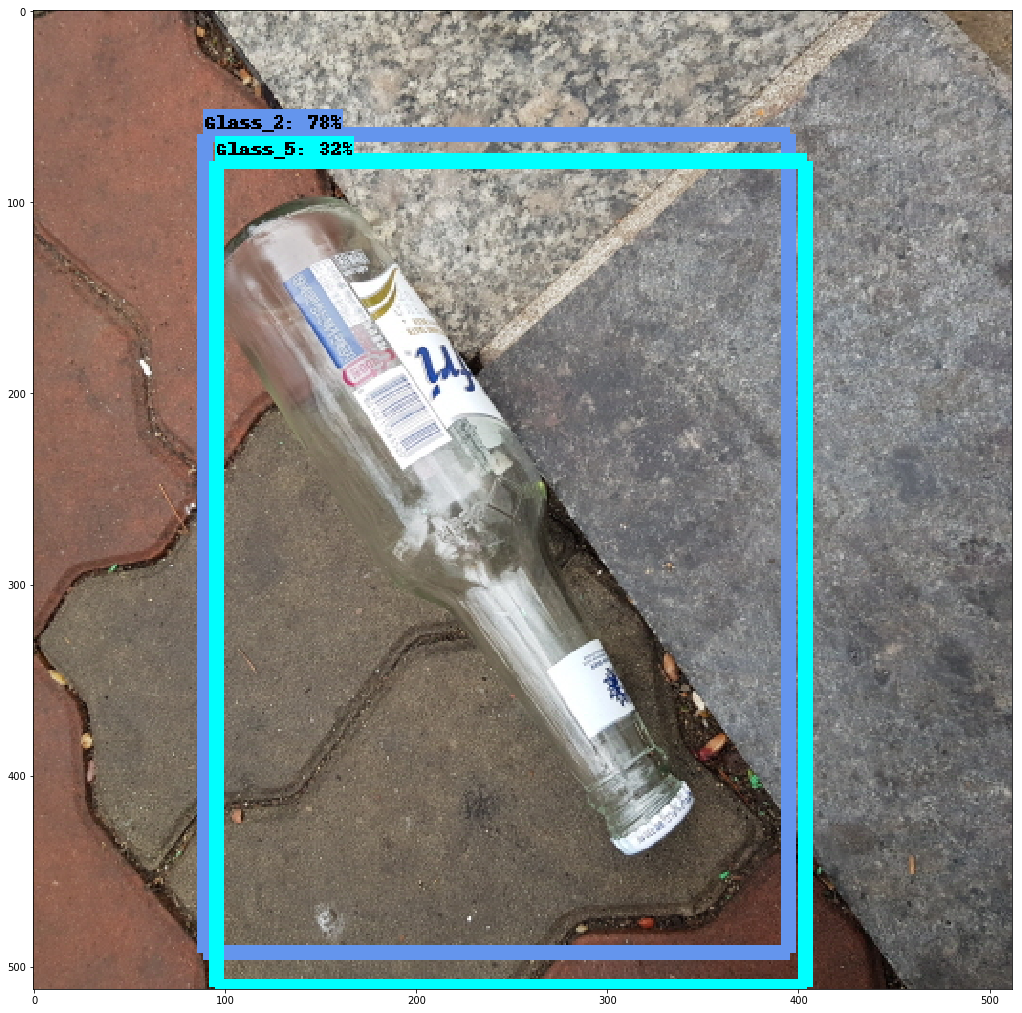

/home/xerato/workspace/models/research/object_detection/test_images/image14.jpg


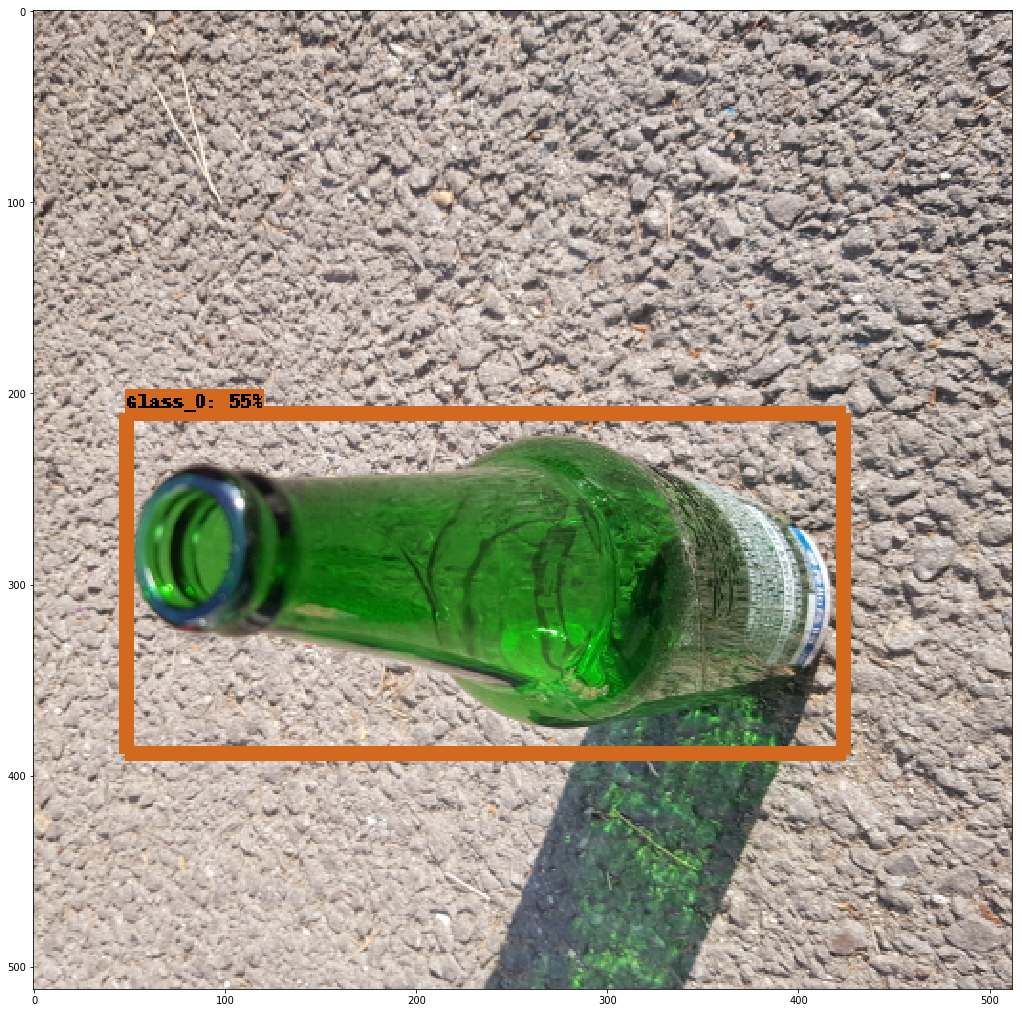

/home/xerato/workspace/models/research/object_detection/test_images/image15.jpg


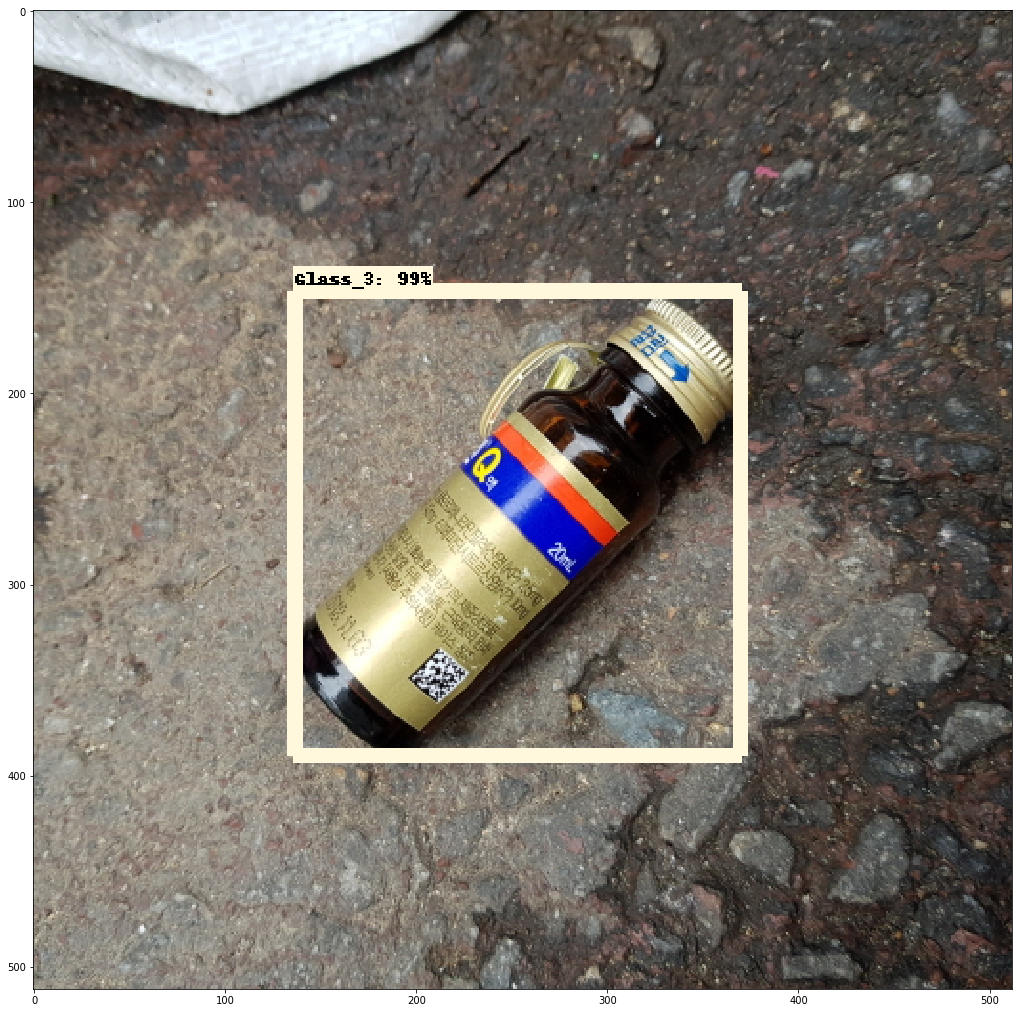

/home/xerato/workspace/models/research/object_detection/test_images/image16.jpg


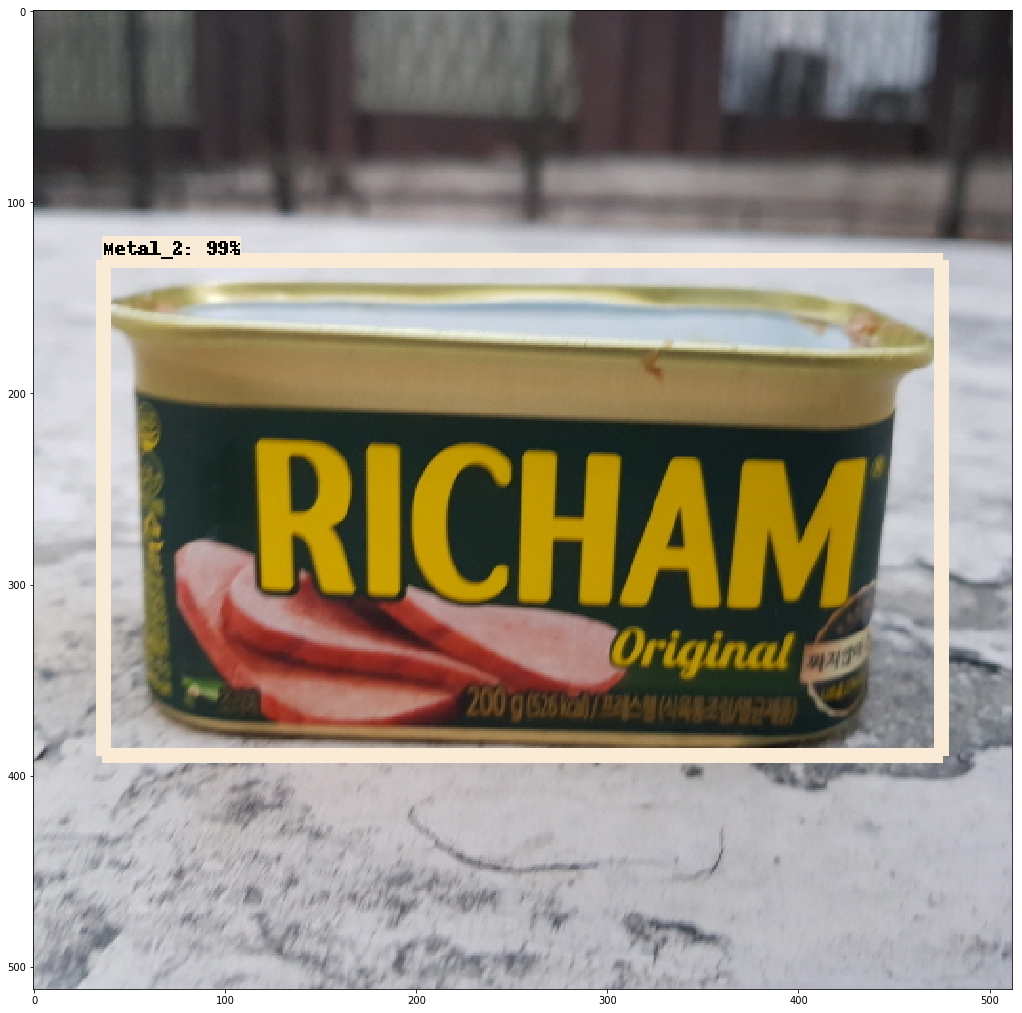

/home/xerato/workspace/models/research/object_detection/test_images/image17.jpg


FileNotFoundError: [Errno 2] No such file or directory: '/home/xerato/workspace/models/research/object_detection/test_images/image17.jpg'

In [14]:
exec_test()